# Data Cleaning and Preprocessing for ML

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

from data_utils import load_dataset_as_df

In [27]:
data_fp = Path("data/marketing_campaign_analytics.csv")
df = load_dataset_as_df(data_fp)
print(f"Dataset loaded with {df.shape[0]} rows and {df.shape[1]} columns.")
print(f"    Features: {df.columns}")
print(df.head(3))

Dataset loaded with 2020 rows and 12 columns.
    Features: Index(['Campaign_ID', 'Campaign_Name', 'Start_Date', 'End_Date', 'Channel',
       'Impressions', 'Clicks', 'Spend', 'Conversions', 'Active', 'Clicks.1',
       'Campaign_Tag'],
      dtype='object')
  Campaign_ID        Campaign_Name           Start_Date    End_Date   Channel  \
0   CMP-00001  Q4_Summer_CMP-00001  2023-11-24 00:00:00  2023-12-13    TikTok   
1   CMP-00002  Q1_Launch_CMP-00002  2023-05-06 00:00:00  2023-05-12  Facebook   
2   CMP-00003  Q3_Winter_CMP-00003  2023-12-13 00:00:00  2023-12-20     Email   

   Impressions  Clicks    Spend  Conversions Active  Clicks.1 Campaign_Tag  
0        16795     197  $102.82         20.0      Y       NaN           TI  
1         1860      30    24.33          1.0      0       NaN           FA  
2        77820     843  1323.39         51.0     No       NaN           EM  


# Cleaning the Dataset
This dataset is quite messy. The column labels have leading/trainling spaces and two columns have the same name. The date columns are not uniformly formatted and dollar amounts only sometime use a `$` symbol.

In [28]:
''' 01 Fixing Column Labels & Duplicates'''
print(f"Before processing:\n{df.columns.tolist()}")
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_')
df = df.loc[:, ~df.columns.duplicated()]
print(f"After processing:\n{df.columns.tolist()}")

Before processing:
['Campaign_ID', 'Campaign_Name', 'Start_Date', 'End_Date', 'Channel', 'Impressions', 'Clicks', 'Spend', 'Conversions', 'Active', 'Clicks.1', 'Campaign_Tag']
After processing:
['campaign_id', 'campaign_name', 'start_date', 'end_date', 'channel', 'impressions', 'clicks', 'spend', 'conversions', 'active', 'clicks.1', 'campaign_tag']


In [29]:
''' 02 Converting Types '''
spend_mask = df['spend'].astype(str).str.contains(r'\$') # mask to look into same data before and after processing
print(f"Before processing:\n{df.loc[spend_mask, ['campaign_id', 'spend']].head(3)}")

df['spend'] = df['spend'].astype(str).str.replace(r'[^\d.-]', '', regex=True)
df['spend'] = pd.to_numeric(df['spend'])
print(f"After processing:\n{df.loc[spend_mask, ['campaign_id', 'spend']].head(3)}")

Before processing:
   campaign_id     spend
0    CMP-00001   $102.82
21   CMP-00022   $2428.4
22   CMP-00023  $4726.22
After processing:
   campaign_id    spend
0    CMP-00001   102.82
21   CMP-00022  2428.40
22   CMP-00023  4726.22


In [30]:
''' 03 Categorical Typos'''
print(f"Before processing:\n{df['channel'].unique()}")

df['channel'] = df['channel'].str.strip() # get rid of whitespaces

cleanup_map = {
    'Facebok': 'Facebook',
    'Tik_Tok': 'TikTok',
    'Inta_gram': 'Instagram',
    'Gogle': 'Google Ads',
    'E-mail': 'Email',
    'N/A': np.nan
}

df['channel'] = df['channel'].replace(cleanup_map)
print(f"After processing:\n{df['channel'].unique()}")

Before processing:
['TikTok' 'Facebook' 'Email' 'Instagram' 'Google Ads' 'E-mail' nan 'Gogle'
 'Tik_Tok' 'Facebok' 'Insta_gram']
After processing:
['TikTok' 'Facebook' 'Email' 'Instagram' 'Google Ads' nan 'Insta_gram']


In [31]:
''' 04 Normalize Boolean Values'''
print(f"Before processing:\n{df['active'].unique()}")
df['active'] = df['active'].str.strip()
bool_map = {
    'Y': True,
    'Yes': True,
    '1': True,
    1: True,
    0: False,
    '0': False,
    'No': False
}
df['active'] = df['active'].replace(bool_map).fillna(False).astype(bool)
print(f"After processing:\n{df['active'].unique()}")

Before processing:
['Y' '0' 'No' 'True' 'Yes' '1' 'False']
After processing:
[ True False]


In [32]:
''' 05 Date Parsing '''
print(f"Before processing: column type = {df['start_date'].dtype}")
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['end_data'] = pd.to_datetime(df['end_date'], errors='coerce')
print(f"After processing: column type = {df['start_date'].dtype}")

Before processing: column type = object
After processing: column type = datetime64[ns]


In [33]:
''' 06 Logical Integrity Check '''
# clicks cannot be higher than impressions
impossible_mask = df['clicks'] > df['impressions']
print(df.loc[impossible_mask, ['campaign_id', 'impressions', 'clicks']].head(3))
print()

# end date cannot be earlier than start data
time_travel_mask = df['end_date'] < df['start_date']
print(f"Before fixes:\n{df.loc[time_travel_mask, ['campaign_id', 'start_date', 'end_date']].head(3)}")
# manual fixes - assuming campaigns end 30 days from start date
df.loc[time_travel_mask, 'end_date'] = df.loc[time_travel_mask, 'start_date'] + pd.Timedelta(days=30)
print(f"After fixes:\n{df.loc[time_travel_mask, ['campaign_id', 'start_date', 'end_date']].head(3)}")

Empty DataFrame
Columns: [campaign_id, impressions, clicks]
Index: []

Before fixes:
   campaign_id start_date    end_date
23   CMP-00024 2023-05-06  2023-05-01
54   CMP-00055 2023-09-01  2023-08-27
71   CMP-00072 2023-02-01  2023-01-27
After fixes:
   campaign_id start_date             end_date
23   CMP-00024 2023-05-06  2023-06-05 00:00:00
54   CMP-00055 2023-09-01  2023-10-01 00:00:00
71   CMP-00072 2023-02-01  2023-03-03 00:00:00


Before processing:
     campaign_id      spend
789    CMP-00790  500000.00
1443   CMP-01444    8921.51
1460   CMP-01461  500000.00


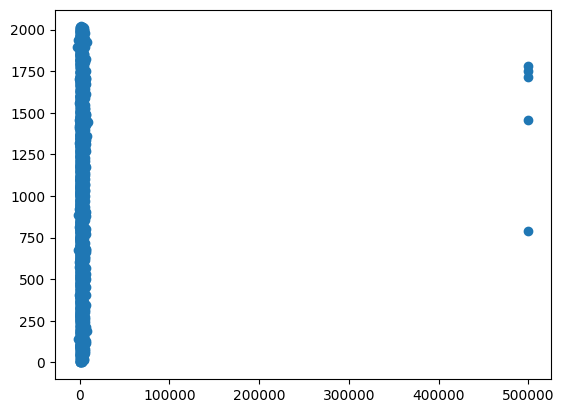

After processing:
     campaign_id      spend
789    CMP-00790  8603.5375
1443   CMP-01444  8603.5375
1460   CMP-01461  8603.5375


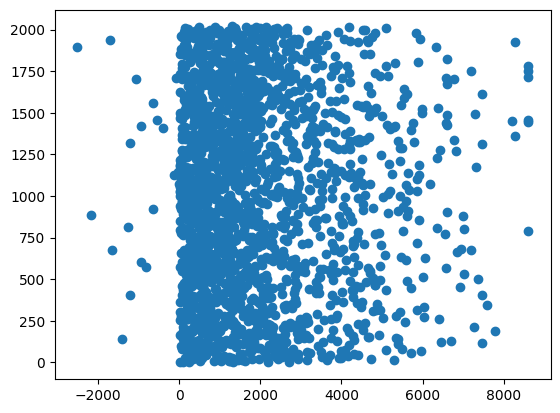

In [34]:
''' 07 Handling Outliers'''
q1 = df['spend'].quantile(0.25)
q3 = df['spend'].quantile(0.75)
iqr = q3 - q1
upper_limit = q3 + (3 * iqr)
outlier_mask = df['spend'] > upper_limit

print(f"Before processing:\n{df.loc[outlier_mask, ['campaign_id', 'spend']].head(3)}")
plt.scatter(df['spend'], range(len(df['spend'])))
plt.show()

# instead of removing outliers, cap them at upper limit
df.loc[outlier_mask, 'spend'] = upper_limit
print(f"After processing:\n{df.loc[outlier_mask, ['campaign_id', 'spend']].head(3)}")
plt.scatter(df['spend'], range(len(df['spend'])))
plt.show()

In [35]:
''' 08 Feature Extraction '''
df['season'] = df['campaign_name'].str.extract(r'Q\d_([^_]+)_') # create a new 'season' column
print(df[['campaign_name', 'season']].head(3))
print(df['season'].unique())

         campaign_name  season
0  Q4_Summer_CMP-00001  Summer
1  Q1_Launch_CMP-00002  Launch
2  Q3_Winter_CMP-00003  Winter
['Summer' 'Launch' 'Winter' 'BlackFriday']


# Preprocessing & Feature Engineering